In [4]:
# Install necessary libraries
!pip install pytorch-tabnet
!pip install captum
!pip install optuna
!pip install imbalanced-learn
!pip install dask-expr
!pip install scikit-learn-contrib
!pip install lightgbm
!pip install ctgan  # Add this for CTGAN

# Data manipulation and analysis
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing and modeling
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Deep Learning Model
from pytorch_tabnet.tab_model import TabNetClassifier

# Explainable AI
import shap

# Hyperparameter Optimization
import optuna
from optuna import Trial

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# For model saving and loading
import joblib
import pickle  # Add pickle for CTGAN loading

# Import torch for TabNet
import torch

# Additional imports for Permutation Regularization
import torch.nn as nn

ERROR: Could not find a version that satisfies the requirement scikit-learn-contrib (from versions: none)
ERROR: No matching distribution found for scikit-learn-contrib


First five rows of the dataset:
   baseline value  accelerations  fetal_movement  uterine_contractions  \
0           120.0          0.000             0.0                 0.000   
1           132.0          0.006             0.0                 0.006   
2           133.0          0.003             0.0                 0.008   
3           134.0          0.003             0.0                 0.008   
4           132.0          0.007             0.0                 0.008   

   light_decelerations  severe_decelerations  prolongued_decelerations  \
0                0.000                   0.0                       0.0   
1                0.003                   0.0                       0.0   
2                0.003                   0.0                       0.0   
3                0.003                   0.0                       0.0   
4                0.000                   0.0                       0.0   

   abnormal_short_term_variability  mean_value_of_short_term_variability  \
0 

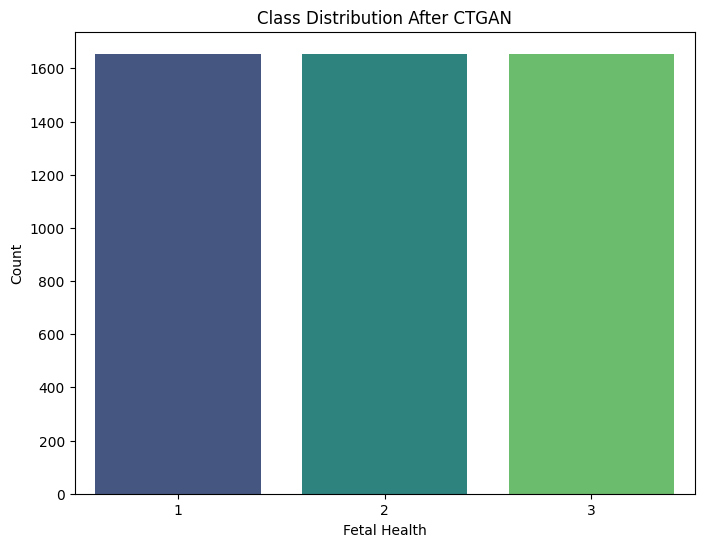

In [5]:
# -------------------
# 3. Load and Preprocess the Dataset
# -------------------
# Load the dataset
data = pd.read_csv('/content/fetal_health.csv')  # Update path if needed

# Display the first five rows to verify
print("First five rows of the dataset:")
print(data.head())

# Check the shape of the dataset
print(f"\nDataset Shape: {data.shape}")

# Features to drop based on prior analysis (same as original)
features_to_drop = [
    'fetal_movement', 'histogram_width', 'histogram_max', 'mean_value_of_long_term_variability',
    'histogram_number_of_peaks', 'light_decelerations', 'histogram_tendency',
    'histogram_number_of_zeroes', 'severe_decelerations', 'baseline value', 'histogram_min'
]

# Drop the specified features
data_dropped = data.drop(columns=features_to_drop)

# Verify the remaining features
print("\nFeatures after dropping less important ones:")
print(data_dropped.columns.tolist())

# Check the new shape of the dataset
print(f"\nNew Dataset Shape after dropping features: {data_dropped.shape}")

# Convert 'fetal_health' to integer
data_dropped['fetal_health'] = data_dropped['fetal_health'].astype(int)

# Mapping numerical classes to descriptive labels
health_mapping = {1: 'Normal', 2: 'Suspect', 3: 'Pathological'}
data_dropped['fetal_health_label'] = data_dropped['fetal_health'].map(health_mapping)

# Display the mapping
print("\nDataset with Mapped Labels:")
print(data_dropped[['fetal_health', 'fetal_health_label']].head())

# Features and target
X = data_dropped.drop(['fetal_health', 'fetal_health_label'], axis=1)
y = data_dropped['fetal_health']

# --- Replace ADASYN + Tomek with CTGAN ---
# Load pre-trained CTGAN models (upload ctgan_suspect.pkl and ctgan_pathological.pkl to Colab first)
with open('/content/ctgan_suspect.pkl', 'rb') as f:
    ctgan_suspect = pickle.load(f)
with open('/content/ctgan_pathological.pkl', 'rb') as f:
    ctgan_pathological = pickle.load(f)

# Scale original features (CTGAN models were trained on scaled data)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# Number of synthetic samples to balance with Normal (1655)
n_suspect = 1655 - 295  # 1360
n_pathological = 1655 - 176  # 1479

# Generate synthetic samples using CTGAN
synthetic_suspect = ctgan_suspect.sample(n_suspect)
synthetic_pathological = ctgan_pathological.sample(n_pathological)

# Combine synthetic data
synthetic_data = pd.concat([synthetic_suspect, synthetic_pathological], ignore_index=True)
synthetic_df = synthetic_data.drop('fetal_health', axis=1)
synthetic_labels = synthetic_data['fetal_health']

# Combine with original data
X_resampled = pd.concat([X_scaled, synthetic_df], ignore_index=True)
y_resampled = pd.concat([y, synthetic_labels], ignore_index=True)

# Display the shape and class distribution
print(f"\nResampled X shape after CTGAN: {X_resampled.shape}")
print(f"Resampled y distribution after CTGAN:\n{y_resampled.value_counts()}")

# Visualize the resampled class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x=y_resampled, palette='viridis')
plt.title('Class Distribution After CTGAN')
plt.xlabel('Fetal Health')
plt.ylabel('Count')
plt.show()

In [6]:
# Split the resampled data (70% train, 30% test) with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled
)

# Display the shapes of the training and testing sets
print(f"\nTraining set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

# Initialize the MinMaxScaler (already scaled, but reassign for consistency)
X_train_scaled = pd.DataFrame(X_train, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test, columns=X.columns)

# Verify scaling by checking min and max values
print("\nMin of Scaled Training Features (Should be 0):")
print(X_train_scaled.min())
print("\nMax of Scaled Training Features (Should be 1):")
print(X_train_scaled.max())

# Adjust the target values so they start from 0
y_train = y_train - 1
y_test = y_test - 1

# Display the adjusted target distributions
print("\nAdjusted y_train distribution:")
print(pd.Series(y_train).value_counts())
print("\nAdjusted y_test distribution:")
print(pd.Series(y_test).value_counts())

# Further split the training data into training and validation sets (80% train, 20% validation)
X_train_final, X_valid, y_train_final, y_valid = train_test_split(
    X_train_scaled, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# Display the shapes of the final training and validation sets
print(f"\nFinal Training set shape: {X_train_final.shape}")
print(f"Validation set shape: {X_valid.shape}")


Training set shape: (3475, 10)
Testing set shape: (1490, 10)

Min of Scaled Training Features (Should be 0):
accelerations                                            -0.114280
uterine_contractions                                     -0.337867
prolongued_decelerations                                 -0.252885
abnormal_short_term_variability                          -0.123320
mean_value_of_short_term_variability                     -0.146603
percentage_of_time_with_abnormal_long_term_variability   -0.166119
histogram_mode                                           -0.268054
histogram_mean                                           -0.122386
histogram_median                                         -0.156802
histogram_variance                                       -0.299106
dtype: float64

Max of Scaled Training Features (Should be 1):
accelerations                                             0.947368
uterine_contractions                                      1.183233
prolongued_deceleration

In [7]:
# Define the objective function for Optuna
def objective(trial: Trial):
    # Define the hyperparameter space
    n_d = trial.suggest_int('n_d', 32, 128)
    n_a = trial.suggest_int('n_a', 32, 128)
    n_steps = trial.suggest_int('n_steps', 3, 10)
    gamma = trial.suggest_float('gamma', 1.0, 2.0)
    lambda_sparse = trial.suggest_float('lambda_sparse', 1e-4, 1e-2, log=True)
    learning_rate = trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True)
    batch_size = trial.suggest_categorical('batch_size', [128, 256, 512])

    # Initialize TabNet with current hyperparameters
    tabnet = TabNetClassifier(
        n_d=n_d,
        n_a=n_a,
        n_steps=n_steps,
        gamma=gamma,
        lambda_sparse=lambda_sparse,
        optimizer_fn=torch.optim.Adam,
        optimizer_params=dict(lr=learning_rate),
        mask_type='sparsemax',
        verbose=0
    )

    # Train the model on the final training set
    tabnet.fit(
        X_train=X_train_final.values,
        y_train=y_train_final.values,
        eval_set=[(X_valid.values, y_valid.values)],
        eval_name=['valid'],
        eval_metric=['accuracy'],
        max_epochs=100,
        patience=20,
        batch_size=batch_size,
        virtual_batch_size=128,
        num_workers=0,
        drop_last=False
    )

    # Predict on the validation set
    y_pred = tabnet.predict(X_valid.values)
    accuracy = accuracy_score(y_valid, y_pred)

    return accuracy

# Create and optimize the Optuna study
study = optuna.create_study(direction='maximize', study_name='TabNet Hyperparameter Optimization')
study.optimize(objective, n_trials=50, timeout=3600)  # Adjust n_trials and timeout as needed

# Display the best hyperparameters and validation accuracy
print("Best Hyperparameters: ", study.best_params)
print("Best Validation Accuracy: ", study.best_value)

[I 2025-03-01 05:32:07,545] A new study created in memory with name: TabNet Hyperparameter Optimization


Stop training because you reached max_epochs = 100 with best_epoch = 96 and best_valid_accuracy = 0.94676


[I 2025-03-01 05:33:28,564] Trial 0 finished with value: 0.9467625899280575 and parameters: {'n_d': 69, 'n_a': 108, 'n_steps': 7, 'gamma': 1.8130168201748105, 'lambda_sparse': 0.000593536406492887, 'learning_rate': 0.02007527513864254, 'batch_size': 256}. Best is trial 0 with value: 0.9467625899280575.



Early stopping occurred at epoch 85 with best_epoch = 65 and best_valid_accuracy = 0.9223


[I 2025-03-01 05:34:10,249] Trial 1 finished with value: 0.9223021582733812 and parameters: {'n_d': 59, 'n_a': 52, 'n_steps': 8, 'gamma': 1.6585383753433987, 'lambda_sparse': 0.0002047708040076128, 'learning_rate': 0.0256740883732765, 'batch_size': 512}. Best is trial 0 with value: 0.9467625899280575.
[I 2025-03-01 05:34:38,830] Trial 2 finished with value: 0.9251798561151079 and parameters: {'n_d': 39, 'n_a': 53, 'n_steps': 4, 'gamma': 1.5218765611554943, 'lambda_sparse': 0.00010847642191020549, 'learning_rate': 0.0033485269614736447, 'batch_size': 512}. Best is trial 0 with value: 0.9467625899280575.


Stop training because you reached max_epochs = 100 with best_epoch = 97 and best_valid_accuracy = 0.92518


[I 2025-03-01 05:35:11,988] Trial 3 finished with value: 0.9280575539568345 and parameters: {'n_d': 70, 'n_a': 69, 'n_steps': 3, 'gamma': 1.4208144754779668, 'lambda_sparse': 0.006040621736588851, 'learning_rate': 0.001178566855644744, 'batch_size': 256}. Best is trial 0 with value: 0.9467625899280575.



Early stopping occurred at epoch 84 with best_epoch = 64 and best_valid_accuracy = 0.92806
Stop training because you reached max_epochs = 100 with best_epoch = 96 and best_valid_accuracy = 0.91799


[I 2025-03-01 05:36:05,645] Trial 4 finished with value: 0.9179856115107914 and parameters: {'n_d': 115, 'n_a': 82, 'n_steps': 8, 'gamma': 1.537978032139152, 'lambda_sparse': 0.00032895542567258515, 'learning_rate': 0.0025860895795922485, 'batch_size': 512}. Best is trial 0 with value: 0.9467625899280575.


Stop training because you reached max_epochs = 100 with best_epoch = 91 and best_valid_accuracy = 0.90216


[I 2025-03-01 05:36:48,530] Trial 5 finished with value: 0.902158273381295 and parameters: {'n_d': 119, 'n_a': 74, 'n_steps': 7, 'gamma': 1.6714321376989836, 'lambda_sparse': 0.001095232971957352, 'learning_rate': 0.0010061437834230566, 'batch_size': 512}. Best is trial 0 with value: 0.9467625899280575.


Stop training because you reached max_epochs = 100 with best_epoch = 99 and best_valid_accuracy = 0.92662


[I 2025-03-01 05:37:31,988] Trial 6 finished with value: 0.9266187050359712 and parameters: {'n_d': 115, 'n_a': 91, 'n_steps': 7, 'gamma': 1.2636874282156965, 'lambda_sparse': 0.0057957737186864, 'learning_rate': 0.010382098278671694, 'batch_size': 512}. Best is trial 0 with value: 0.9467625899280575.



Early stopping occurred at epoch 80 with best_epoch = 60 and best_valid_accuracy = 0.93669


[I 2025-03-01 05:38:30,962] Trial 7 finished with value: 0.9366906474820144 and parameters: {'n_d': 33, 'n_a': 83, 'n_steps': 8, 'gamma': 1.030945696534022, 'lambda_sparse': 0.00011255479592218362, 'learning_rate': 0.0019276632725064044, 'batch_size': 256}. Best is trial 0 with value: 0.9467625899280575.



Early stopping occurred at epoch 86 with best_epoch = 66 and best_valid_accuracy = 0.94388


[I 2025-03-01 05:39:14,127] Trial 8 finished with value: 0.943884892086331 and parameters: {'n_d': 92, 'n_a': 66, 'n_steps': 5, 'gamma': 1.7928900152681244, 'lambda_sparse': 0.00268009477839061, 'learning_rate': 0.026631735451122854, 'batch_size': 256}. Best is trial 0 with value: 0.9467625899280575.



Early stopping occurred at epoch 97 with best_epoch = 77 and best_valid_accuracy = 0.91942


[I 2025-03-01 05:39:56,690] Trial 9 finished with value: 0.9194244604316547 and parameters: {'n_d': 44, 'n_a': 71, 'n_steps': 7, 'gamma': 1.975073896411791, 'lambda_sparse': 0.0005323455316685954, 'learning_rate': 0.01284212909731312, 'batch_size': 512}. Best is trial 0 with value: 0.9467625899280575.



Early stopping occurred at epoch 81 with best_epoch = 61 and best_valid_accuracy = 0.93381


[I 2025-03-01 05:42:05,356] Trial 10 finished with value: 0.9338129496402877 and parameters: {'n_d': 93, 'n_a': 121, 'n_steps': 10, 'gamma': 1.9849671831300837, 'lambda_sparse': 0.0011899379823264013, 'learning_rate': 0.09016342096667075, 'batch_size': 128}. Best is trial 0 with value: 0.9467625899280575.



Early stopping occurred at epoch 64 with best_epoch = 44 and best_valid_accuracy = 0.92374


[I 2025-03-01 05:42:38,433] Trial 11 finished with value: 0.9237410071942446 and parameters: {'n_d': 90, 'n_a': 106, 'n_steps': 5, 'gamma': 1.7948788815304966, 'lambda_sparse': 0.0026487784200583185, 'learning_rate': 0.033610993069671524, 'batch_size': 256}. Best is trial 0 with value: 0.9467625899280575.


Stop training because you reached max_epochs = 100 with best_epoch = 82 and best_valid_accuracy = 0.9482


[I 2025-03-01 05:43:28,304] Trial 12 finished with value: 0.9482014388489208 and parameters: {'n_d': 82, 'n_a': 39, 'n_steps': 5, 'gamma': 1.8199525370756227, 'lambda_sparse': 0.002110417717319748, 'learning_rate': 0.029058894037876853, 'batch_size': 256}. Best is trial 12 with value: 0.9482014388489208.



Early stopping occurred at epoch 27 with best_epoch = 7 and best_valid_accuracy = 0.84317


[I 2025-03-01 05:43:42,389] Trial 13 finished with value: 0.8431654676258993 and parameters: {'n_d': 72, 'n_a': 34, 'n_steps': 5, 'gamma': 1.7984650260751982, 'lambda_sparse': 0.0006110981776147322, 'learning_rate': 0.07031276877618949, 'batch_size': 256}. Best is trial 12 with value: 0.9482014388489208.



Early stopping occurred at epoch 86 with best_epoch = 66 and best_valid_accuracy = 0.93957


[I 2025-03-01 05:45:10,918] Trial 14 finished with value: 0.939568345323741 and parameters: {'n_d': 58, 'n_a': 123, 'n_steps': 6, 'gamma': 1.8635970604718013, 'lambda_sparse': 0.002204397590901215, 'learning_rate': 0.007502098559629983, 'batch_size': 128}. Best is trial 12 with value: 0.9482014388489208.



Early stopping occurred at epoch 82 with best_epoch = 62 and best_valid_accuracy = 0.91511


[I 2025-03-01 05:46:24,278] Trial 15 finished with value: 0.9151079136690647 and parameters: {'n_d': 83, 'n_a': 104, 'n_steps': 10, 'gamma': 1.6575075832741788, 'lambda_sparse': 0.009858398776915163, 'learning_rate': 0.03993680651956455, 'batch_size': 256}. Best is trial 12 with value: 0.9482014388489208.
[I 2025-03-01 05:46:54,199] Trial 16 finished with value: 0.9467625899280575 and parameters: {'n_d': 103, 'n_a': 37, 'n_steps': 3, 'gamma': 1.3267658077689395, 'lambda_sparse': 0.0014853710465568084, 'learning_rate': 0.016498931144576595, 'batch_size': 256}. Best is trial 12 with value: 0.9482014388489208.



Early stopping occurred at epoch 87 with best_epoch = 67 and best_valid_accuracy = 0.94676
Stop training because you reached max_epochs = 100 with best_epoch = 93 and best_valid_accuracy = 0.9223


[I 2025-03-01 05:47:51,811] Trial 17 finished with value: 0.9223021582733812 and parameters: {'n_d': 56, 'n_a': 103, 'n_steps': 6, 'gamma': 1.8777450385582528, 'lambda_sparse': 0.0005860698746981756, 'learning_rate': 0.005401089622465986, 'batch_size': 256}. Best is trial 12 with value: 0.9482014388489208.



Early stopping occurred at epoch 53 with best_epoch = 33 and best_valid_accuracy = 0.9223


[I 2025-03-01 05:49:08,146] Trial 18 finished with value: 0.9223021582733812 and parameters: {'n_d': 70, 'n_a': 51, 'n_steps': 9, 'gamma': 1.6955828761262328, 'lambda_sparse': 0.0002793117285600803, 'learning_rate': 0.051021863743632934, 'batch_size': 128}. Best is trial 12 with value: 0.9482014388489208.



Early stopping occurred at epoch 68 with best_epoch = 48 and best_valid_accuracy = 0.93525


[I 2025-03-01 05:49:37,690] Trial 19 finished with value: 0.935251798561151 and parameters: {'n_d': 80, 'n_a': 94, 'n_steps': 4, 'gamma': 1.57085196809894, 'lambda_sparse': 0.0019065623341612654, 'learning_rate': 0.022419354738293533, 'batch_size': 256}. Best is trial 12 with value: 0.9482014388489208.



Early stopping occurred at epoch 95 with best_epoch = 75 and best_valid_accuracy = 0.94676


[I 2025-03-01 05:50:32,955] Trial 20 finished with value: 0.9467625899280575 and parameters: {'n_d': 104, 'n_a': 114, 'n_steps': 6, 'gamma': 1.1110246351971762, 'lambda_sparse': 0.0036641569166262398, 'learning_rate': 0.018204795634213688, 'batch_size': 256}. Best is trial 12 with value: 0.9482014388489208.
[I 2025-03-01 05:50:54,906] Trial 21 finished with value: 0.9381294964028777 and parameters: {'n_d': 100, 'n_a': 35, 'n_steps': 3, 'gamma': 1.3349825893672285, 'lambda_sparse': 0.0014804490218860349, 'learning_rate': 0.01528083040342535, 'batch_size': 256}. Best is trial 12 with value: 0.9482014388489208.



Early stopping occurred at epoch 63 with best_epoch = 43 and best_valid_accuracy = 0.93813

Early stopping occurred at epoch 54 with best_epoch = 34 and best_valid_accuracy = 0.9223


[I 2025-03-01 05:51:17,801] Trial 22 finished with value: 0.9223021582733812 and parameters: {'n_d': 80, 'n_a': 44, 'n_steps': 4, 'gamma': 1.189458441773203, 'lambda_sparse': 0.0008222604418608145, 'learning_rate': 0.007167264971724088, 'batch_size': 256}. Best is trial 12 with value: 0.9482014388489208.
[I 2025-03-01 05:51:41,860] Trial 23 finished with value: 0.9381294964028777 and parameters: {'n_d': 105, 'n_a': 59, 'n_steps': 3, 'gamma': 1.4029500916395077, 'lambda_sparse': 0.0008537870529334091, 'learning_rate': 0.05377357218515587, 'batch_size': 256}. Best is trial 12 with value: 0.9482014388489208.



Early stopping occurred at epoch 70 with best_epoch = 50 and best_valid_accuracy = 0.93813

Early stopping occurred at epoch 58 with best_epoch = 38 and best_valid_accuracy = 0.92374


[I 2025-03-01 05:52:11,397] Trial 24 finished with value: 0.9237410071942446 and parameters: {'n_d': 127, 'n_a': 42, 'n_steps': 5, 'gamma': 1.4580194825712287, 'lambda_sparse': 0.0014388604490439228, 'learning_rate': 0.017146308533032506, 'batch_size': 256}. Best is trial 12 with value: 0.9482014388489208.



Early stopping occurred at epoch 56 with best_epoch = 36 and best_valid_accuracy = 0.9295


[I 2025-03-01 05:52:53,285] Trial 25 finished with value: 0.9294964028776979 and parameters: {'n_d': 65, 'n_a': 42, 'n_steps': 4, 'gamma': 1.3059559258472329, 'lambda_sparse': 0.003456450914494032, 'learning_rate': 0.03402653844344627, 'batch_size': 128}. Best is trial 12 with value: 0.9482014388489208.



Early stopping occurred at epoch 67 with best_epoch = 47 and best_valid_accuracy = 0.90791


[I 2025-03-01 05:53:32,182] Trial 26 finished with value: 0.9079136690647482 and parameters: {'n_d': 51, 'n_a': 32, 'n_steps': 6, 'gamma': 1.891014519601094, 'lambda_sparse': 0.00042158754124955593, 'learning_rate': 0.009897063400083977, 'batch_size': 256}. Best is trial 12 with value: 0.9482014388489208.
[I 2025-03-01 05:54:02,541] Trial 27 finished with value: 0.9453237410071943 and parameters: {'n_d': 84, 'n_a': 60, 'n_steps': 3, 'gamma': 1.602268878675042, 'lambda_sparse': 0.0016171238565492168, 'learning_rate': 0.021547862908002233, 'batch_size': 256}. Best is trial 12 with value: 0.9482014388489208.



Early stopping occurred at epoch 90 with best_epoch = 70 and best_valid_accuracy = 0.94532

Early stopping occurred at epoch 89 with best_epoch = 69 and best_valid_accuracy = 0.92662


[I 2025-03-01 05:55:15,144] Trial 28 finished with value: 0.9266187050359712 and parameters: {'n_d': 96, 'n_a': 94, 'n_steps': 9, 'gamma': 1.7303404743381579, 'lambda_sparse': 0.0008190097871612558, 'learning_rate': 0.013040530520969684, 'batch_size': 256}. Best is trial 12 with value: 0.9482014388489208.



Early stopping occurred at epoch 61 with best_epoch = 41 and best_valid_accuracy = 0.93813


[I 2025-03-01 05:56:35,559] Trial 29 finished with value: 0.9381294964028777 and parameters: {'n_d': 108, 'n_a': 52, 'n_steps': 8, 'gamma': 1.2276395709485195, 'lambda_sparse': 0.0001903542795017346, 'learning_rate': 0.027035724056136703, 'batch_size': 128}. Best is trial 12 with value: 0.9482014388489208.



Early stopping occurred at epoch 64 with best_epoch = 44 and best_valid_accuracy = 0.94101


[I 2025-03-01 05:57:03,214] Trial 30 finished with value: 0.9410071942446043 and parameters: {'n_d': 76, 'n_a': 128, 'n_steps': 4, 'gamma': 1.3589239214669202, 'lambda_sparse': 0.0045147497080449545, 'learning_rate': 0.00503408592496595, 'batch_size': 256}. Best is trial 12 with value: 0.9482014388489208.


Stop training because you reached max_epochs = 100 with best_epoch = 90 and best_valid_accuracy = 0.94532


[I 2025-03-01 05:58:01,321] Trial 31 finished with value: 0.9453237410071943 and parameters: {'n_d': 106, 'n_a': 116, 'n_steps': 6, 'gamma': 1.096073148695938, 'lambda_sparse': 0.003411577376532353, 'learning_rate': 0.01877634396489933, 'batch_size': 256}. Best is trial 12 with value: 0.9482014388489208.



Early stopping occurred at epoch 71 with best_epoch = 51 and best_valid_accuracy = 0.94101


[I 2025-03-01 05:58:48,223] Trial 32 finished with value: 0.9410071942446043 and parameters: {'n_d': 100, 'n_a': 115, 'n_steps': 7, 'gamma': 1.1061603786327756, 'lambda_sparse': 0.002024688613321335, 'learning_rate': 0.043889955495168616, 'batch_size': 256}. Best is trial 12 with value: 0.9482014388489208.



Early stopping occurred at epoch 82 with best_epoch = 62 and best_valid_accuracy = 0.94245


[I 2025-03-01 05:59:29,310] Trial 33 finished with value: 0.9424460431654677 and parameters: {'n_d': 87, 'n_a': 111, 'n_steps': 5, 'gamma': 1.169539805898824, 'lambda_sparse': 0.004026871862489076, 'learning_rate': 0.029292675237687166, 'batch_size': 256}. Best is trial 12 with value: 0.9482014388489208.



Early stopping occurred at epoch 85 with best_epoch = 65 and best_valid_accuracy = 0.9223


[I 2025-03-01 06:00:18,534] Trial 34 finished with value: 0.9223021582733812 and parameters: {'n_d': 67, 'n_a': 100, 'n_steps': 6, 'gamma': 1.4825990523215373, 'lambda_sparse': 0.008393173213857501, 'learning_rate': 0.010488175236177467, 'batch_size': 256}. Best is trial 12 with value: 0.9482014388489208.


Stop training because you reached max_epochs = 100 with best_epoch = 91 and best_valid_accuracy = 0.9482


[I 2025-03-01 06:01:01,995] Trial 35 finished with value: 0.9482014388489208 and parameters: {'n_d': 127, 'n_a': 78, 'n_steps': 7, 'gamma': 1.0935183107679007, 'lambda_sparse': 0.005607343256354971, 'learning_rate': 0.017203598142651978, 'batch_size': 512}. Best is trial 12 with value: 0.9482014388489208.


Stop training because you reached max_epochs = 100 with best_epoch = 84 and best_valid_accuracy = 0.94388


[I 2025-03-01 06:01:50,519] Trial 36 finished with value: 0.943884892086331 and parameters: {'n_d': 128, 'n_a': 47, 'n_steps': 8, 'gamma': 1.0256674944992834, 'lambda_sparse': 0.006889211735659215, 'learning_rate': 0.013851617419082342, 'batch_size': 512}. Best is trial 12 with value: 0.9482014388489208.


Stop training because you reached max_epochs = 100 with best_epoch = 87 and best_valid_accuracy = 0.8964


[I 2025-03-01 06:02:33,939] Trial 37 finished with value: 0.8964028776978418 and parameters: {'n_d': 118, 'n_a': 85, 'n_steps': 7, 'gamma': 1.6239580702531322, 'lambda_sparse': 0.005306693774595824, 'learning_rate': 0.008710136236495126, 'batch_size': 512}. Best is trial 12 with value: 0.9482014388489208.


Stop training because you reached max_epochs = 100 with best_epoch = 94 and best_valid_accuracy = 0.93669


[I 2025-03-01 06:03:16,861] Trial 38 finished with value: 0.9366906474820144 and parameters: {'n_d': 112, 'n_a': 76, 'n_steps': 7, 'gamma': 1.5358181264844626, 'lambda_sparse': 0.001064210023499235, 'learning_rate': 0.02123576143599012, 'batch_size': 512}. Best is trial 12 with value: 0.9482014388489208.


Stop training because you reached max_epochs = 100 with best_epoch = 86 and best_valid_accuracy = 0.91223


[I 2025-03-01 06:04:05,336] Trial 39 finished with value: 0.9122302158273381 and parameters: {'n_d': 123, 'n_a': 62, 'n_steps': 8, 'gamma': 1.744257814185068, 'lambda_sparse': 0.0003869943818516412, 'learning_rate': 0.004080208482668854, 'batch_size': 512}. Best is trial 12 with value: 0.9482014388489208.


Stop training because you reached max_epochs = 100 with best_epoch = 90 and best_valid_accuracy = 0.9295


[I 2025-03-01 06:04:59,556] Trial 40 finished with value: 0.9294964028776979 and parameters: {'n_d': 51, 'n_a': 87, 'n_steps': 9, 'gamma': 1.9460872048355529, 'lambda_sparse': 0.0026648224639779622, 'learning_rate': 0.011917449802311204, 'batch_size': 512}. Best is trial 12 with value: 0.9482014388489208.


Stop training because you reached max_epochs = 100 with best_epoch = 90 and best_valid_accuracy = 0.93957


[I 2025-03-01 06:05:43,208] Trial 41 finished with value: 0.939568345323741 and parameters: {'n_d': 113, 'n_a': 78, 'n_steps': 7, 'gamma': 1.1040150867611835, 'lambda_sparse': 0.004395756963682241, 'learning_rate': 0.017657345330279937, 'batch_size': 512}. Best is trial 12 with value: 0.9482014388489208.



Early stopping occurred at epoch 93 with best_epoch = 73 and best_valid_accuracy = 0.93669


[I 2025-03-01 06:06:37,681] Trial 42 finished with value: 0.9366906474820144 and parameters: {'n_d': 62, 'n_a': 39, 'n_steps': 6, 'gamma': 1.270891240561045, 'lambda_sparse': 0.003268816698760669, 'learning_rate': 0.02471049420598083, 'batch_size': 256}. Best is trial 12 with value: 0.9482014388489208.



Early stopping occurred at epoch 68 with best_epoch = 48 and best_valid_accuracy = 0.93813


[I 2025-03-01 06:07:12,682] Trial 43 finished with value: 0.9381294964028777 and parameters: {'n_d': 75, 'n_a': 111, 'n_steps': 5, 'gamma': 1.1495185728487205, 'lambda_sparse': 0.007169501568029148, 'learning_rate': 0.03433081749751209, 'batch_size': 256}. Best is trial 12 with value: 0.9482014388489208.


Stop training because you reached max_epochs = 100 with best_epoch = 88 and best_valid_accuracy = 0.9482


[I 2025-03-01 06:08:01,454] Trial 44 finished with value: 0.9482014388489208 and parameters: {'n_d': 120, 'n_a': 67, 'n_steps': 8, 'gamma': 1.0476052843886314, 'lambda_sparse': 0.0052926154859915175, 'learning_rate': 0.01620057054360051, 'batch_size': 512}. Best is trial 12 with value: 0.9482014388489208.



Early stopping occurred at epoch 87 with best_epoch = 67 and best_valid_accuracy = 0.93669


[I 2025-03-01 06:08:44,758] Trial 45 finished with value: 0.9366906474820144 and parameters: {'n_d': 122, 'n_a': 68, 'n_steps': 8, 'gamma': 1.0126540437711897, 'lambda_sparse': 0.005337271261262433, 'learning_rate': 0.01521481843267545, 'batch_size': 512}. Best is trial 12 with value: 0.9482014388489208.


Stop training because you reached max_epochs = 100 with best_epoch = 99 and best_valid_accuracy = 0.94101


[I 2025-03-01 06:09:28,653] Trial 46 finished with value: 0.9410071942446043 and parameters: {'n_d': 118, 'n_a': 71, 'n_steps': 7, 'gamma': 1.0605522056681387, 'lambda_sparse': 0.0006821819620452867, 'learning_rate': 0.007467923079831372, 'batch_size': 512}. Best is trial 12 with value: 0.9482014388489208.


Stop training because you reached max_epochs = 100 with best_epoch = 88 and best_valid_accuracy = 0.91942


[I 2025-03-01 06:10:22,917] Trial 47 finished with value: 0.9194244604316547 and parameters: {'n_d': 124, 'n_a': 55, 'n_steps': 9, 'gamma': 1.2356442602805082, 'lambda_sparse': 0.001267681149325903, 'learning_rate': 0.0020428451670107175, 'batch_size': 512}. Best is trial 12 with value: 0.9482014388489208.



Early stopping occurred at epoch 98 with best_epoch = 78 and best_valid_accuracy = 0.9223


[I 2025-03-01 06:11:11,606] Trial 48 finished with value: 0.9223021582733812 and parameters: {'n_d': 111, 'n_a': 64, 'n_steps': 8, 'gamma': 1.9283504382850438, 'lambda_sparse': 0.002359024790218105, 'learning_rate': 0.030123677898072236, 'batch_size': 512}. Best is trial 12 with value: 0.9482014388489208.


Stop training because you reached max_epochs = 100 with best_epoch = 82 and best_valid_accuracy = 0.94964


[I 2025-03-01 06:11:55,603] Trial 49 finished with value: 0.9496402877697842 and parameters: {'n_d': 95, 'n_a': 82, 'n_steps': 7, 'gamma': 1.0604035581458195, 'lambda_sparse': 0.00023309579931048954, 'learning_rate': 0.06385200251604904, 'batch_size': 512}. Best is trial 49 with value: 0.9496402877697842.


Best Hyperparameters:  {'n_d': 95, 'n_a': 82, 'n_steps': 7, 'gamma': 1.0604035581458195, 'lambda_sparse': 0.00023309579931048954, 'learning_rate': 0.06385200251604904, 'batch_size': 512}
Best Validation Accuracy:  0.9496402877697842


In [8]:
# -------------------
# Part 1: Data Augmentation Function
# -------------------
def augment_data(X, y, permutation_prob=0.1):
    """
    Augment the dataset by randomly permuting feature orders with a given probability.

    Parameters:
    - X (numpy.ndarray or pandas.DataFrame): Feature matrix.
    - y (numpy.ndarray or pandas.Series): Target vector.
    - permutation_prob (float): Probability of permuting each sample.

    Returns:
    - X_augmented (numpy.ndarray): Augmented feature matrix.
    - y_augmented (numpy.ndarray): Augmented target vector.
    """
    X_augmented = []
    y_augmented = []
    for sample, label in zip(X, y):
        if np.random.rand() < permutation_prob:
            perm = np.random.permutation(sample.shape[0])
            sample = sample[perm]
        X_augmented.append(sample)
        y_augmented.append(label)
    return np.array(X_augmented), np.array(y_augmented)

# -------------------
# Part 2: Apply Data Augmentation
# -------------------
permutation_probability = 0.1
X_train_augmented, y_train_augmented = augment_data(
    X_train_final.values,
    y_train_final.values,
    permutation_prob=permutation_probability
)

print(f"Original Training Set Shape: {X_train_final.shape}")
print(f"Augmented Training Set Shape: {X_train_augmented.shape}")

# -------------------
# Part 3: Initialize and Train TabNet with Augmented Data
# -------------------
perm_reg_tabnet = TabNetClassifier(
    input_dim=X_train_final.shape[1],    # Number of features (10)
    output_dim=3,                        # Number of classes: Normal, Suspect, Pathological
    n_d=study.best_params['n_d'],
    n_a=study.best_params['n_a'],
    n_steps=study.best_params['n_steps'],
    gamma=study.best_params['gamma'],
    lambda_sparse=study.best_params['lambda_sparse'],
    optimizer_fn=torch.optim.Adam,
    optimizer_params={'lr': study.best_params['learning_rate']},
    mask_type='sparsemax',
    verbose=1,
    seed=42
)

perm_reg_tabnet.fit(
    X_train=X_train_augmented,
    y_train=y_train_augmented,
    eval_set=[(X_valid.values, y_valid.values), (X_test_scaled.values, y_test.values)],
    eval_name=['train', 'valid'],
    eval_metric=['accuracy'],
    max_epochs=100,
    patience=20,
    batch_size=study.best_params['batch_size'],
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False
)

Original Training Set Shape: (2780, 10)
Augmented Training Set Shape: (2780, 10)
epoch 0  | loss: 3.14036 | train_accuracy: 0.34676 | valid_accuracy: 0.34631 |  0:00:00s
epoch 1  | loss: 2.06169 | train_accuracy: 0.41439 | valid_accuracy: 0.42215 |  0:00:01s
epoch 2  | loss: 0.857   | train_accuracy: 0.39856 | valid_accuracy: 0.4255  |  0:00:01s
epoch 3  | loss: 0.59457 | train_accuracy: 0.52662 | valid_accuracy: 0.54698 |  0:00:02s
epoch 4  | loss: 0.55823 | train_accuracy: 0.71511 | valid_accuracy: 0.72416 |  0:00:02s
epoch 5  | loss: 0.56698 | train_accuracy: 0.57842 | valid_accuracy: 0.5906  |  0:00:03s
epoch 6  | loss: 0.50694 | train_accuracy: 0.61727 | valid_accuracy: 0.6255  |  0:00:03s
epoch 7  | loss: 0.4583  | train_accuracy: 0.76691 | valid_accuracy: 0.73893 |  0:00:04s
epoch 8  | loss: 0.43688 | train_accuracy: 0.70504 | valid_accuracy: 0.68658 |  0:00:04s
epoch 9  | loss: 0.43313 | train_accuracy: 0.77986 | valid_accuracy: 0.74832 |  0:00:05s
epoch 10 | loss: 0.43383 | tr


Permutation Regularized TabNet Classification Report:
              precision    recall  f1-score   support

      Normal       0.94      0.93      0.94       496
     Suspect       0.88      0.95      0.92       497
Pathological       0.98      0.91      0.94       497

    accuracy                           0.93      1490
   macro avg       0.93      0.93      0.93      1490
weighted avg       0.93      0.93      0.93      1490



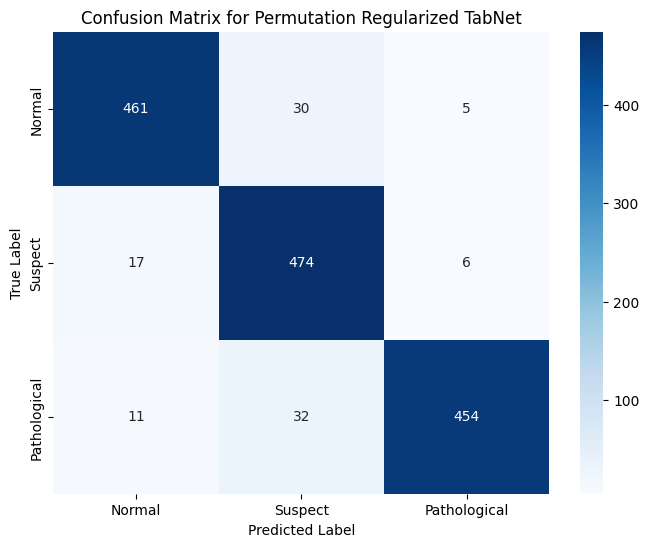

In [9]:
# -------------------
# Part 4: Predict and Evaluate on the Test Set
# -------------------
y_pred_perm_reg = perm_reg_tabnet.predict(X_test_scaled.values)

print("\nPermutation Regularized TabNet Classification Report:")
print(classification_report(y_test, y_pred_perm_reg, target_names=['Normal', 'Suspect', 'Pathological']))

conf_matrix = confusion_matrix(y_test, y_pred_perm_reg)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Suspect', 'Pathological'],
            yticklabels=['Normal', 'Suspect', 'Pathological'])
plt.title('Confusion Matrix for Permutation Regularized TabNet')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()